In [1]:
import os.path as osp

import PIL.Image as PImage
from torchvision.datasets.folder import DatasetFolder, IMG_EXTENSIONS
from torchvision.transforms import InterpolationMode, transforms

import os
import os.path as osp
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import gc
import os
import shutil
import sys
import time
import warnings
from functools import partial

import torch
from torch.utils.data import DataLoader

import dist

In [2]:
class NPYImageDataset(Dataset):
    def __init__(self, npy_path, image_dir, transform=None):
        self.data = np.load(npy_path)
        self.image_dir = image_dir
        self.transform = transform
        
        assert self.data.shape[1] == 1025, f"数据形状应为(n, 1025)，但得到{self.data.shape}"
        
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.tiff', '.jpg', '.jpeg', '.bmp'))]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        latent_vector = self.data[idx, :1024] 
        image_label = int(self.data[idx, 1024]) 
        
        image_path = osp.join(self.image_dir, f"natural_scene_{image_label}.tiff")
        
        try:
            img = Image.open(image_path).convert('L') 
        except FileNotFoundError:
            img = Image.new('L', (256, 256), color=0)
            print(f"Warning: image {image_path} disappear")
        
        if self.transform:
            img = self.transform(img)
        
        latent_vector = torch.tensor(latent_vector, dtype=torch.float32)
        
        return img, latent_vector

def build_dataset(
    data_path: str, 
    final_reso: int
):
    transform = transforms.Compose([
        transforms.Resize((final_reso, final_reso)),  
        transforms.ToTensor(),                       
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Lambda(lambda x: x * 2 - 1)         
    ])
    
    train_set = NPYImageDataset(
        npy_path=osp.join(data_path, 'VISp_train_features.npy'),
        image_dir=osp.join('/media/ubuntu/sda/neuropixels/nature_scene'),
        transform=transform
    )
    
    val_set = NPYImageDataset(
        npy_path=osp.join(data_path, 'VISp_eval_features.npy'),
        image_dir=osp.join('/media/ubuntu/sda/neuropixels/nature_scene'),
        transform=transform
    )
    
    num_classes = 1000  
    
    return num_classes, train_set, val_set

In [ ]:
num_classes, train_set, val_set = build_dataset(data_path = '/media/ubuntu/sda/neuropixels/visual_decode', final_reso = 256)

In [4]:
ld_val = DataLoader(
            val_set, num_workers=2, pin_memory=True,
            batch_size=3,
            shuffle=False, drop_last=False,
        )

ld_train = DataLoader(
            dataset=train_set, num_workers=2, pin_memory=True,
            shuffle=True, drop_last = False, batch_size = 3
        )

In [11]:
a = np.load("/media/ubuntu/sda/neuropixels/visual_decode/VISp_train_features.npy")

In [12]:
a.shape

(4680, 1025)

In [5]:
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====


# download checkpoint
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'

# build vae, var
FOR_512_px = MODEL_DEPTH == 16
# if FOR_512_px:
#     patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
# else:
#     patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=False)


/home/ubuntu/.conda/envs/visual_decoding/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


_IncompatibleKeys(missing_keys=['shared_ada_lin.1.weight', 'shared_ada_lin.1.bias', 'blocks.0.ada_gss', 'blocks.1.ada_gss', 'blocks.2.ada_gss', 'blocks.3.ada_gss', 'blocks.4.ada_gss', 'blocks.5.ada_gss', 'blocks.6.ada_gss', 'blocks.7.ada_gss', 'blocks.8.ada_gss', 'blocks.9.ada_gss', 'blocks.10.ada_gss', 'blocks.11.ada_gss', 'blocks.12.ada_gss', 'blocks.13.ada_gss', 'blocks.14.ada_gss', 'blocks.15.ada_gss'], unexpected_keys=['blocks.0.ada_lin.1.weight', 'blocks.0.ada_lin.1.bias', 'blocks.1.ada_lin.1.weight', 'blocks.1.ada_lin.1.bias', 'blocks.2.ada_lin.1.weight', 'blocks.2.ada_lin.1.bias', 'blocks.3.ada_lin.1.weight', 'blocks.3.ada_lin.1.bias', 'blocks.4.ada_lin.1.weight', 'blocks.4.ada_lin.1.bias', 'blocks.5.ada_lin.1.weight', 'blocks.5.ada_lin.1.bias', 'blocks.6.ada_lin.1.weight', 'blocks.6.ada_lin.1.bias', 'blocks.7.ada_lin.1.weight', 'blocks.7.ada_lin.1.bias', 'blocks.8.ada_lin.1.weight', 'blocks.8.ada_lin.1.bias', 'blocks.9.ada_lin.1.weight', 'blocks.9.ada_lin.1.bias', 'blocks.10.a

In [6]:
# names, paras, para_groups = filter_params(var, nowd_keys={
#     'cls_token', 'start_token', 'task_token', 'cfg_uncond',
#     'pos_embed', 'pos_1LC', 'pos_start', 'start_pos', 'lvl_embed',
#     'gamma', 'beta',
#     'ada_gss', 'moe_bias',
#     'scale_mul',
# })
# opt_clz = {
#     'adam':  partial(torch.optim.AdamW, betas=(0.9, 0.95), fused=True),
#     'adamw': partial(torch.optim.AdamW, betas=(0.9, 0.95), fused=True),
# }['adamw'.lower().strip()]
# opt_kw = dict(lr=1e-4, weight_decay=0)
# print(f'[INIT] optim={opt_clz}, opt_kw={opt_kw}\n')

# var_optim = AmpOptimizer(
#     mixed_precision=0, optimizer=opt_clz(params=para_groups, **opt_kw), names=names, paras=paras,
#     grad_clip=2., n_gradient_accumulation=1
# )

In [7]:
import torch.nn as nn
loss_func = nn.CrossEntropyLoss(label_smoothing=True, reduction='none')

In [8]:
import torch.optim as optim

optimizer = optim.Adam(var.parameters(), lr=0.00001)


In [9]:
vae.eval()
for batch_image, batch_labels in ld_train:
    batch_image = batch_image.to(device)
    batch_labels = batch_labels.to(device)

    gt_idx_Bl = vae.img_to_idxBl(batch_image)
    gt_BL = torch.cat(gt_idx_Bl, dim=1)
    x_BLCv_wo_first_l = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
    B = batch_labels.shape[0]
    break

In [11]:
batch_image.shape

torch.Size([3, 3, 256, 256])

In [12]:
gt_idx_Bl

[tensor([[3498],
         [2640],
         [ 994]], device='cuda:0'),
 tensor([[3445, 3632,  495,  434],
         [ 914, 3558,  101, 1052],
         [1882, 2148, 3642, 1764]], device='cuda:0'),
 tensor([[2640, 2276,  528, 1882, 2189,  685,  655,  687, 2715],
         [1809, 3825, 2408, 1902, 2248, 2640, 2733, 1739, 3863],
         [3532, 1125,  928,  971, 1122, 3264, 3321, 1924, 2952]],
        device='cuda:0'),
 tensor([[1315, 2218,  780,  252, 1872, 3849,  685,  446, 2123,  755,  136, 4016,
          1166,   77, 2849, 2767],
         [2334, 4016, 2052,  755, 2593, 3764, 4080, 1914, 4094, 1521, 1973,  780,
          1788, 3554,  132, 3523],
         [3382,  602, 3231, 3566,  495, 3710, 1981, 2127, 2828, 3781, 2608, 1266,
          1813, 2943, 1090,  712]], device='cuda:0'),
 tensor([[3611, 1202, 2979, 3603, 2144, 2659, 1907, 1300, 1972,  101, 2198, 1233,
           187, 2575, 3513,  649,  269,  756,  759,  432, 1818, 4070, 1940, 3106,
          2472],
         [2031, 1890, 3965, 2066,

In [103]:
vae.eval()
for epoch in range(5):
    var.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_image, batch_labels in ld_train:
        batch_image = batch_image.to(device)
        batch_labels = batch_labels.to(device)

        gt_idx_Bl = vae.img_to_idxBl(batch_image)
        gt_BL = torch.cat(gt_idx_Bl, dim=1)
        x_BLCv_wo_first_l = vae.quantize.idxBl_to_var_input(gt_idx_Bl)
        B = batch_labels.shape[0]

        logits_BLV = var(batch_labels, x_BLCv_wo_first_l)
        
        loss = loss_func(logits_BLV.view(-1, vae.vocab_size), gt_BL.view(-1)).view(B, -1)
        loss_weight = torch.ones(1, 680, device=device) / 680
        loss = loss.mul(loss_weight).sum(dim=-1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch 1, Loss: {total_loss /4680}')

Epoch 1, Loss: 2.7726224995066975
Epoch 1, Loss: 2.772614932467795
Epoch 1, Loss: 2.772612508545574
Epoch 1, Loss: 2.7726100344943183
Epoch 1, Loss: 2.772608155063075


In [ ]:
logits_BLV.shape

torch.Size([3, 680, 4096])

: 

In [109]:
x_BLCv_wo_first_l.shape

torch.Size([3, 679, 32])

In [104]:
vae.eval()
var.eval()
total_loss = 0
for batch_image, batch_labels in ld_val:
    batch_image = batch_image.to(device)
    batch_labels = batch_labels.to(device)

    break

In [105]:
batch_image.shape

torch.Size([3, 3, 256, 256])

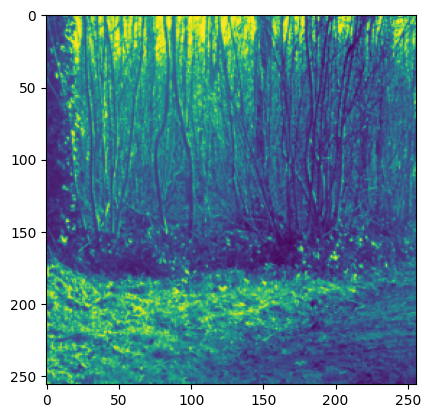

In [106]:
import matplotlib.pyplot as plt
plt.imshow(batch_image[0, 0, :, :].cpu().detach().numpy())

In [107]:
seed = 5 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
B = 3
label_B = batch_labels
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = var.autoregressive_infer_cfg(B=B, label_B=label_B, cfg=cfg, top_k=900, top_p=0.95, g_seed=seed, more_smooth=more_smooth)

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul_(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw.show()
